<a href="https://drive.google.com/file/d/1-lmvLqHRoVztabnwQ8RbZuDhpsd1kmYY/view?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIMBRE

**Research project** for the course of *Selected Topics in Music and Acoustic Engineering* :

***Music Instrument Classification***

This project addresses the development of a system for automatic music instrument classification. The dataset
provided is the MedleyDBcollection1, which contains 196 professionally recorded multitrack recordings, including
individual stems corresponding to isolated instruments.
 
Students are tasked with designing a classification pipeline that either recognizes instruments in multitimbral mix
tures or classifies individual stems where typically one instrument is active. The project encourages a flexible
approach, allowing exploration of both isolated and polyphonic scenarios.

Key aspects to investigate include:
- Analyzing the robustness of instrument recognition systems when facing different levels of overlapping in
struments within a mixture.
- Studying the relationship between instrumentation and musical genre, as genre annotations are also available in the dataset.
- Exploring the use of co-occurrence matrices to model and understand typical combinations of instruments within different musical contexts.
The students should experiment with feature extraction techniques sensitive to timbral characteristics, such as
spectral descriptors and MFCCs, and assess the effectiveness of classification

### Team:
* Andrea Crisafulli
* Marco Porcella
* Giacomo De Toni
* Gianluigi Vecchini

## *Import libraries*:

In [1]:
# === Core Python & Scientific Computing ===
import numpy as np                # Numerical computing
import pandas as pd              # Data handling and manipulation
import matplotlib.pyplot as plt  # Plotting
from pathlib import Path         # File path handling
import scipy.signal as signal    # Signal processing tools

# === Audio Processing ===
import librosa                   # Audio analysis
import librosa.display           # Visualization for librosa outputs
import IPython.display as ipd    # For audio playback in notebooks

# === Scikit-learn: ML & Preprocessing ===
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay  # Evaluation
from sklearn.decomposition import PCA         # Dimensionality reduction
from sklearn.preprocessing import scale, StandardScaler, MultiLabelBinarizer  # Data scaling & encoding
from sklearn.model_selection import train_test_split  # Dataset splitting
from sklearn.svm import SVC                    # Support Vector Classifier
from sklearn.neighbors import KNeighborsClassifier  # k-NN classifier
from sklearn.cluster import KMeans            # Clustering

# === Deep Learning: TensorFlow / Keras ===
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint  # Training utilities
from keras.optimizers import Adam            # Optimizer for model training
from keras import layers, models

# === Optional: PyTorch (if used) ===
#import torch
#import torch.nn as nn
#import torch.nn.functional as F              # Functional API for building models

# === Others ===
import yaml                                   # Parsing metadata in YAML format
from collections import Counter               # Frequency counting for label analysis
from tqdm import tqdm                         # Progress bar for loops

# === Plotting Style ===
#plt.style.use("seaborn-v0_8")                 # Set default plotting style

EXECUTION SETTINGS

In [ ]:
# Variables for data extraction
considerMixFiles = True
considerStemFiles = True
considerRawFiles = False

# Variable for OS recognition
OSys = 0  # 0 = WINDOWS, 1 = MACOS

# Select execution mode for the dataset
executionMode = 1   # 0 = all dataset, 1 = partial dataset

# Select number of classes to extract to form the partial dataset (MAX = 24) (ONLY WORKS IF 1 IS SELECTED FOR executionMode)
n_classes = 3

In [ ]:
# Since 83 different labels are present we can group togheter similar labels (24 macrolabels)
labelGroupsDict = {
    'Main System': 'Main System',               # 12

    # Vocals 
    'male singer': 'vocals',                    # 82
    'female singer': 'vocals',                  # 57
    'male rapper': 'vocals',                    # 8
    'male speaker': 'vocals',                   # 2
    'vocalists': 'vocals',                      # 60 

    # Guitar
    'acoustic guitar': 'guitar',                # 50
    'clean electric guitar': 'guitar',          # 94
    'distorted electric guitar': 'guitar',      # 54
    'lap steel guitar': 'guitar',               

    # Small guitars
    'liuqin': 'similar guitars',               
    'banjo': 'similar guitars',
    'mandolin': 'similar guitars',              # 18
    'oud':'similar guitars',
    'zhongruan':'similar guitars',

    # Electric bass
    'electric bass': 'electric bass',           # 126

    # Violin
    'violin': 'violin',                         # 41
    'violin section': 'violin',                 # 28

    # Viola
    'viola': 'viola',                           # 15
    'viola section': 'viola',                   # 8

    # Cello
    'cello': 'cello',                           # 24
    'cello section': 'cello',

    # double bass
    'double bass': 'strings',                   # 33

    # string section
    'string section': 'strings',                # 12
    'erhu': 'strings',                          # 12

    # Trumpet
    'trumpet': 'brass',                         # 15
    'trumpet section': 'brass',

    # Trombone
    'trombone': 'trombone',
    'trombone section': 'trombone',

    # Trombone
    'french horn': 'french horn',
    'french horn section': 'french horn',

    # Tuba
    'tuba': 'tuba',

    # Brass
    'horn section': 'brass',
    'brass section': 'brass',                   # 16

    # Saxophone
    'saxophone': 'saxophone',
    'soprano saxophone': 'saxophone',
    'alto saxophone': 'saxophone',
    'tenor saxophone': 'saxophone',
    'baritone saxophone': 'saxophone',

    # Woodwinds
    'dizi': 'woodwinds',
    'flute': 'woodwinds',                       # 22
    'flute section': 'woodwinds',
    'piccolo': 'woodwinds',
    'clarinet': 'woodwinds',                    # 17
    'clarinet section': 'woodwinds',
    'bass clarinet': 'woodwinds',
    'oboe': 'woodwinds',
    'bassoon': 'woodwinds',                     # 11
    'bamboo flute' : 'woodwinds',

    # Drum set
    'drum set': 'drum set',                     # 131
    'snare drum': 'drum set',
    'kick drum': 'drum set',
    'bass drum': 'drum set',

    # Percussion
    'toms': 'percussion',
    'doumbek': 'percussion',
    'tabla': 'percussion',                      # 27
    'darbuka': 'percussion',
    'tambourine': 'percussion',
    'shaker': 'percussion',
    'bongo': 'percussion',
    'cymbal': 'percussion',                     # 14
    'timpani': 'percussion',                    # 13
    'auxiliary percussion': 'percussion',       # 36
    'claps': 'percussion',
    'gong': 'percussion',
    'gu':'percussion',
    'drum machine': 'percussion',                 # 32
    'scratches': 'percussion',

    # Xilofono
    'chimes': 'xilofono',
    'glockenspiel':'xilofono',
    'vibraphone':'xilofono',                    # 16

    # Harps
    'guzheng':'harps',
    'harp':'harps',
    'yangqin':'harps',                          # 12

    # Piano
    'piano': 'piano',                           # 86
    'electric piano': 'piano', 

    # Accordion
    'accordion': 'accordion',                   # 10

    # Harmonica
    'harmonica': 'harmonica',                   # 4
    
    # Keyboard and piano
    'tack piano': 'keyboard',                   # 18
    'melodica': 'keyboard',         
    'sampler': 'keyboard',
    'synthesizer': 'keyboard',                  # 74 

    # fx/processed sound
    'fx/processed sound':'fx/processed sound',  # 63 
}

### *Import audio data*:

In [4]:
windows = 0
macOS = 1
errorPath = False

if OSys == windows:
    basePath = Path("E:/MedleyDB")                         # For windows
elif OSys == macOS:
    basePath = Path("/Volumes/Extreme SSD/MedleyDB")        # For mac
else:
    errorPath = True

audioPath = basePath / "Audio"
data = []

if (considerMixFiles or considerStemFiles or considerRawFiles and not errorPath):
    # Iterates over directories in the melodyDB/Audio folder
    for songDir in audioPath.iterdir():
        labelArray = []
        
        # Security check to skip not directory items
        if not songDir.is_dir():
            continue
        
        songName = songDir.name
        yamlFilePath = audioPath / songDir / f"{songName}_METADATA.yaml" # Path to YAML metadata file
        
        # Opens YAML metadata file in read mode
        with open(yamlFilePath, "r") as f:
            metadata = yaml.safe_load(f)
        
        # Recovers stems from metadata and stores in dictionary
        stemsData = metadata.get("stems", {})
        
        # Iterates over stems
        for stemId, stem in stemsData.items():
            instrumentData = [] # Empty data for raw paths
            
            rawData = stem.get("raw", {})
            
            # import Raw files (SKIP FOR NOW)
            if considerRawFiles:
                # Iterates over raw items to store the relative paths
                for rawId, raw in rawData.items():
                    rawPath = songDir /  f"{songName}_RAW" / raw.get("filename")
                    
                    # Checks for valid files
                    if(not rawPath.name.startswith(".")):
                        rawData = {
                            "song": songName,
                            "songPath": audioPath / songDir,
                            "label": labelGroupsDict[stem.get("instrument")],
                            "filePath": rawPath
                        }
                        
                        data.append(rawData)
                
            # Creates new data
            if considerStemFiles:
                stemData = {
                    "song": songName,
                    "songPath": songDir,
                    "label": labelGroupsDict[stem.get("instrument")],
                    "filePath": songDir / f"{songName}_STEMS" / stem.get("filename")
                }
                
                # Appends to data 
                data.append(stemData)
            
            if considerMixFiles:
                labelArray.append(labelGroupsDict[stem.get("instrument")])
        
        if considerMixFiles:
            # Format
            labelArray = np.unique(labelArray)
            labelFormatted = "|".join(sorted(set(labelArray)))
            
            mixData = {
                "song": songName,
                "songPath": audioPath / songDir,
                "label": labelFormatted,
                "filePath": songDir / f"{songName}_MIX.wav"
            }
            
            data.append(mixData)
    # Create DataFrame
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} audio files.")

    # String convertion to list
    df["labelList"] = df["label"].str.split("|")

    mlbAllDataset = MultiLabelBinarizer()
    audioLabelsBinary = mlbAllDataset.fit_transform(df["labelList"])
    audioLabelsBinary = np.asarray(audioLabelsBinary)
elif errorPath:
    print("ERROR: defined OS is not supported.")
else:
    print("ERROR: no data to extract with current setup.")

Loaded 978 audio files.


In [5]:
#Head of dataset
df.head()

song                                      songPath  \
0  AClassicEducation_NightOwl  E:\MedleyDB\Audio\AClassicEducation_NightOwl   
1  AClassicEducation_NightOwl  E:\MedleyDB\Audio\AClassicEducation_NightOwl   
2  AClassicEducation_NightOwl  E:\MedleyDB\Audio\AClassicEducation_NightOwl   
3  AClassicEducation_NightOwl  E:\MedleyDB\Audio\AClassicEducation_NightOwl   
4  AClassicEducation_NightOwl  E:\MedleyDB\Audio\AClassicEducation_NightOwl   

           label                                           filePath  \
0  electric bass  E:\MedleyDB\Audio\AClassicEducation_NightOwl\A...   
1       drum set  E:\MedleyDB\Audio\AClassicEducation_NightOwl\A...   
2         guitar  E:\MedleyDB\Audio\AClassicEducation_NightOwl\A...   
3         guitar  E:\MedleyDB\Audio\AClassicEducation_NightOwl\A...   
4         guitar  E:\MedleyDB\Audio\AClassicEducation_NightOwl\A...   

         labelList  
0  [electric bass]  
1       [drum set]  
2         [guitar]  
3         [guitar]  
4         [guitar]

In [6]:
# Tail of dataset
df.tail()

song                                 songPath  \
973  TheSoSoGlos_Emergency  E:\MedleyDB\Audio\TheSoSoGlos_Emergency   
974  TheSoSoGlos_Emergency  E:\MedleyDB\Audio\TheSoSoGlos_Emergency   
975       Wolf_DieBekherte       E:\MedleyDB\Audio\Wolf_DieBekherte   
976       Wolf_DieBekherte       E:\MedleyDB\Audio\Wolf_DieBekherte   
977       Wolf_DieBekherte       E:\MedleyDB\Audio\Wolf_DieBekherte   

                                                 label  \
973                                           xilofono   
974  drum set|electric bass|fx/processed sound|guit...   
975                                             vocals   
976                                              piano   
977                                       piano|vocals   

                                              filePath  \
973  E:\MedleyDB\Audio\TheSoSoGlos_Emergency\TheSoS...   
974  E:\MedleyDB\Audio\TheSoSoGlos_Emergency\TheSoS...   
975  E:\MedleyDB\Audio\Wolf_DieBekherte\Wolf_DieBek...   
976  E:\MedleyDB\Audio\Wolf_DieBekherte\Wolf_DieBek...   
977  E:\MedleyDB\Audio\Wolf_DieBekherte\Wolf_DieBek...   

                                             labelList  
973                                         [xilofono]  
974  [drum set, electric bass, fx/processed sound, ...  
975                                           [vocals]  
976                                            [piano]  
977                                    [piano, vocals]

In [7]:
# Info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   song       978 non-null    object
 1   songPath   978 non-null    object
 2   label      978 non-null    object
 3   filePath   978 non-null    object
 4   labelList  978 non-null    object
dtypes: object(5)
memory usage: 38.3+ KB


In [8]:
# Mostra tutte le righe e colonne senza troncamento
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


df_labels = pd.DataFrame(audioLabelsBinary, columns=mlbAllDataset.classes_)
df_labels.sum().sort_values(ascending=False)


guitar                184
vocals                180
drum set              138
percussion            130
electric bass         126
keyboard               93
piano                  92
woodwinds              71
violin                 67
fx/processed sound     63
strings                56
brass                  45
similar guitars        35
cello                  31
xilofono               24
harps                  23
viola                  23
french horn            16
saxophone              12
Main System            12
accordion              10
trombone                9
harmonica               4
tuba                    4
dtype: int64

In [10]:
# Storing variables
audioFiles = []
audioLabels = []

# Extract paths and labels
for _, row in df.iterrows():
    audioFiles.append(row["filePath"])
    audioLabels.append(row["labelList"])
    

# Security check
if(len(audioFiles) == len(audioLabels)):
    print(f"Extracted files and labels for a total lenght of {len(audioFiles)}")
else:
    print("Error in dataset")

Extracted files and labels for a total lenght of 978


In [15]:
# Flatten all labels e conta frequenze
all_labels = sum(df["labelList"], [])
label_counts = Counter(all_labels)

if n_classes <= label_counts.total():
    # Prendi le 10 classi più frequenti
    top_labels = [label for label, _ in label_counts.most_common(n_classes)]
    print("Top labels:", top_labels)

    # Filtra righe dove almeno una label è in top_labels
    df_subset = df[df["labelList"].apply(lambda labels: any(label in top_labels for label in labels))]

    # Estrai audio e label
    audioFilesSubset = df_subset["filePath"].tolist()
    audioLabelsSubset = df_subset["labelList"].tolist()

    mlbPartialDataset = MultiLabelBinarizer(classes=top_labels)
    audioLabelsSubsetBinary = mlbPartialDataset.fit_transform(df_subset["labelList"])
    audioLabelsSubsetBinary = np.asarray(audioLabelsSubsetBinary)

    if len(audioFilesSubset) == len(audioLabelsSubset):
        print(f"Extracted {len(audioFilesSubset)} samples from top {n_classes} labels")
    else:
        print("Mismatch in extracted data")

    print(f"Subset binary label matrix shape: {audioLabelsSubsetBinary.shape}")
else:
    print(f"ERROR: selected n_classes of {n_classes} exceeds the total number of classes in DF ({label_counts})")

Top labels: ['guitar', 'vocals', 'drum set']
Extracted 406 samples from top 3 labels
Subset binary label matrix shape: (406, 3)


c:\Users\Marco Porce\Documents\GitHub\SelectedTopic\env\lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['Main System', 'accordion', 'brass', 'cello', 'electric bass', 'french horn', 'fx/processed sound', 'harmonica', 'harps', 'keyboard', 'percussion', 'piano', 'saxophone', 'similar guitars', 'strings', 'trombone', 'viola', 'violin', 'woodwinds', 'xilofono'] will be ignored
  warnings.warn(


In [17]:

allDataset = 0
partialDataset = 1

# if elif block to choose execution mode between all dataset and partial dataset
if executionMode == allDataset:
    mlb = mlbAllDataset                  # mlb to use
    labelsToLoad = audioLabelsBinary     # audioLabels to use
    audioFilesToExtract = audioFiles     # audio files to load
elif executionMode == partialDataset:
    mlb = mlbPartialDataset
    labelsToLoad = audioLabelsSubsetBinary
    audioFilesToExtract = audioFilesSubset

signals = []

timeExtraction = 10  # in seconds
samplingRate = 22050
num_samples = int(samplingRate * timeExtraction)
minAmplitude = 0.5

# Extraction of files via librosa load (TQDM to show progress)
for x in tqdm(audioFilesToExtract, desc="Loading audio files..."):
    y, _ = librosa.load(x, sr=samplingRate)
    
    # Normalizzazione
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    # Trova primo indice significativo
    if np.any(y > minAmplitude):
        start_index = np.argmax(y > minAmplitude)
    else:
        start_index = 0

    # Calcola fine dell’estrazione
    end_index = start_index + num_samples
    
    if end_index <= len(y):
        y = y[start_index:end_index]
    else:
        # Prova a traslare lo start indietro se possibile
        if len(y) >= num_samples:
            start_index = len(y) - num_samples
            y = y[start_index:]
        else:
            # Troppo corto: pad con zeri alla fine
            y = y[start_index:]
            padding_needed = num_samples - len(y)
            y = np.pad(y, (0, padding_needed), 'constant')

    y = y.astype(np.float16)
    signals.append(y)

Loading audio files...: 100%|██████████| 406/406 [03:34<00:00,  1.89it/s]


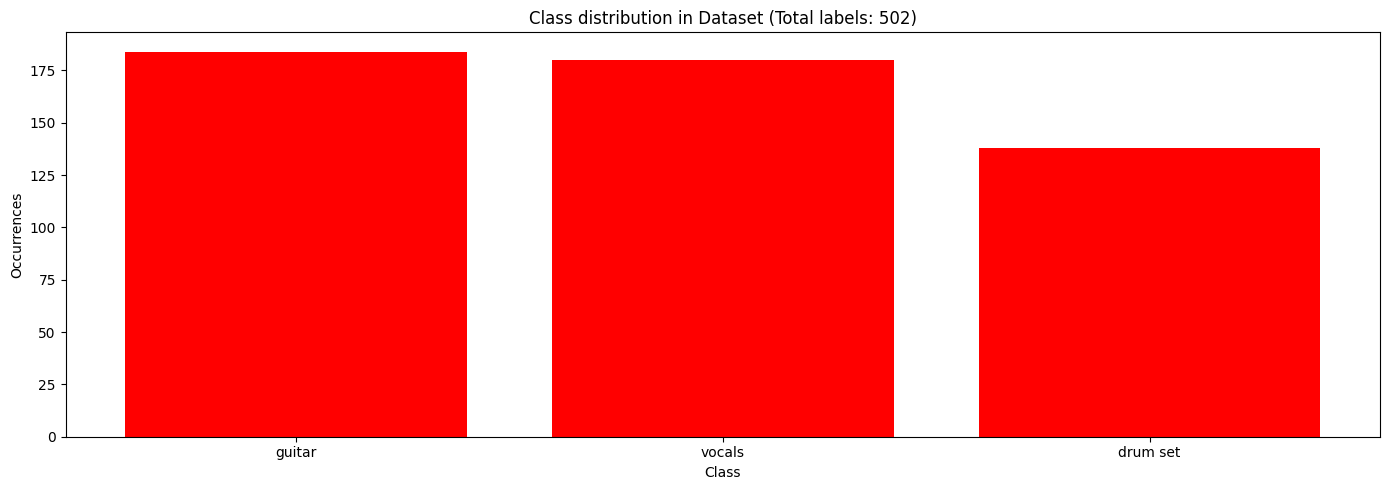

In [37]:
# Conta le occorrenze di "1" per ciascuna classe
class_counts = np.sum(labelsToLoad, axis=0)
n_classes = labelsToLoad.shape[1]

# Plot
plt.figure(figsize=(14, 5))
plt.bar(range(n_classes), class_counts, color='red')  # Usa bar(), non hist()

# Asse x e titoli
plt.xlabel('Class')
plt.ylabel('Occurrences')
plt.xticks(range(n_classes), mlb.classes_)
plt.title(f'Class distribution in Dataset (Total labels: {int(np.sum(labelsToLoad))})')
plt.tight_layout()
plt.show()

In [ ]:
## SIGNAL AUGMENTATION

In [38]:
melSpegrams = []

# Iterates over signals, normalizes them and computes mel spectrograms via librosa feature
for signal in tqdm(signals, desc="Processing audio signals..."):

    # Creation of mel spectrogram
    S = librosa.feature.melspectrogram(y=signal, sr=22050)
    S_dB = librosa.power_to_db(S, ref=np.max)
    melSpegrams.append(S_dB)

Processing audio signals...: 100%|██████████| 406/406 [00:06<00:00, 63.43it/s]




-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('drum set',)]


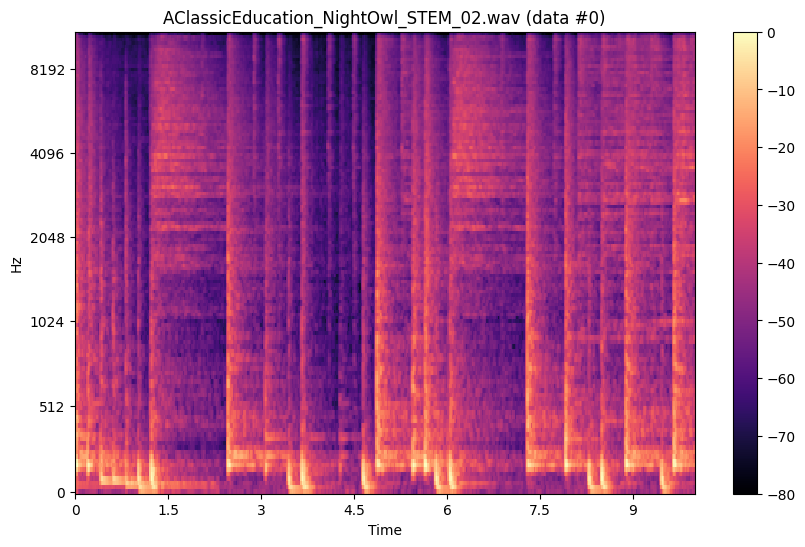



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('drum set',)]


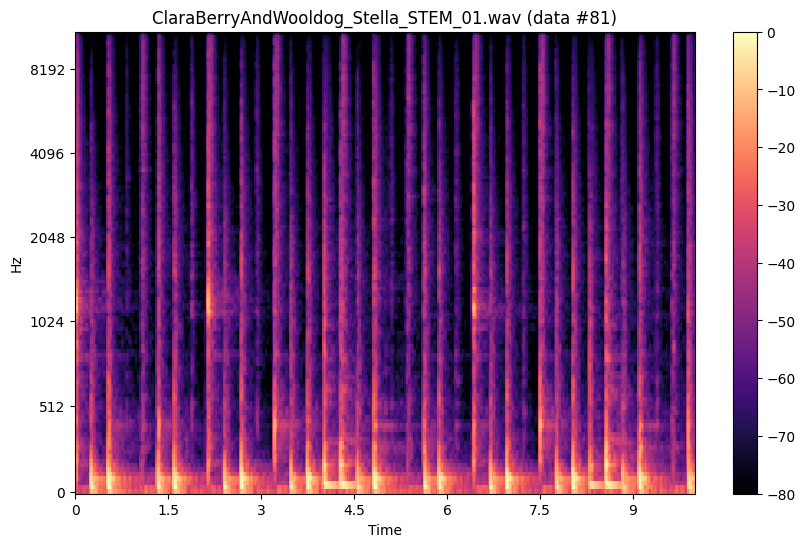



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('drum set',)]


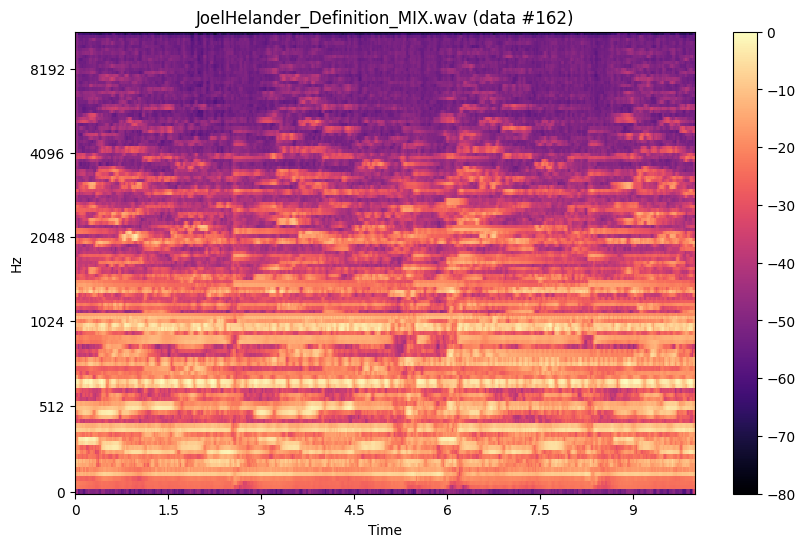



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('drum set',)]


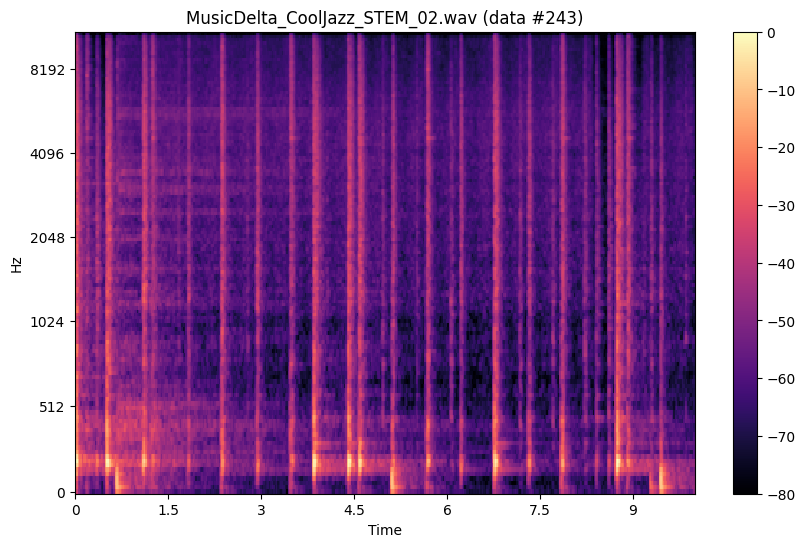



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('guitar',)]


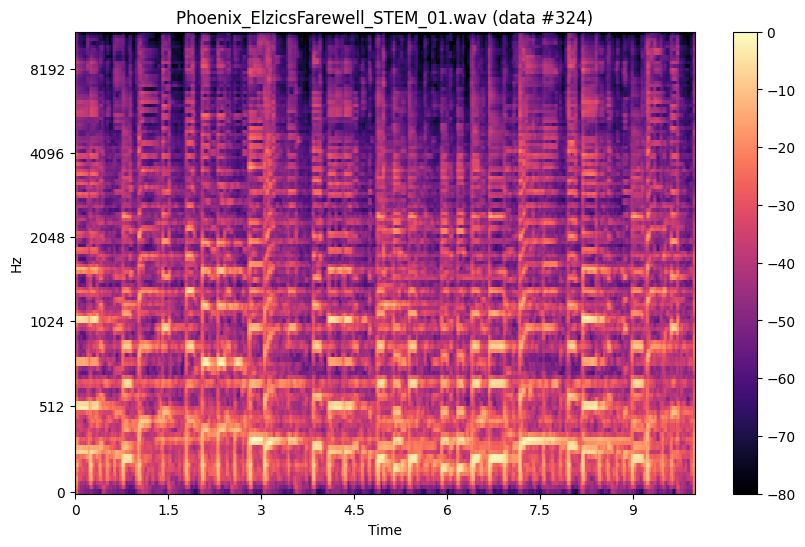



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('vocals',)]


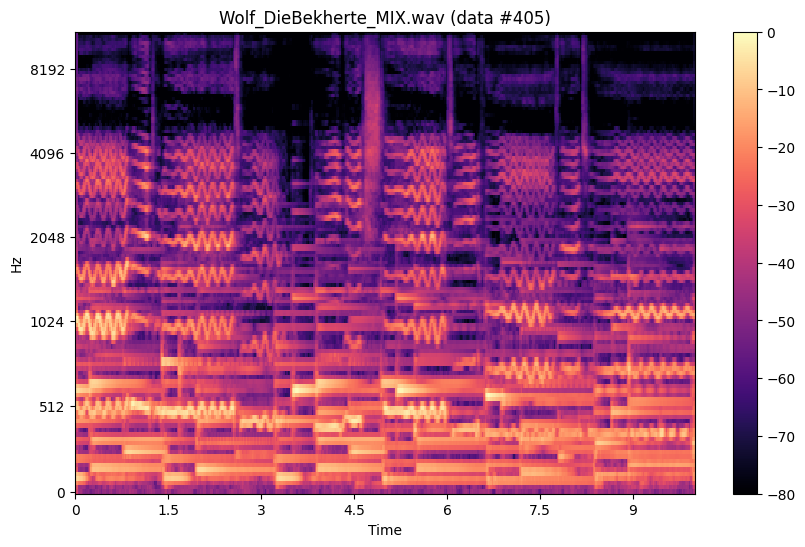

In [39]:
# Plot of spectrograms
import IPython.display

for i in range(0, len(signals), int(len(signals)/5)):
    print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
    
    original_labels = mlb.inverse_transform(np.array([labelsToLoad[i]]))
    print("Labels:", original_labels)

    IPython.display.display(IPython.display.Audio(signals[i], rate=22050))

    plt.figure(figsize=(10,6))
    librosa.display.specshow(melSpegrams[i], sr=22050, x_axis='time', y_axis='mel', fmax=22050/2)
    plt.clim(-80,None)
    plt.colorbar()

    filename = str(audioFilesToExtract[i]).split("\\")[-1]
    
    plt.title(f'{filename} (data #{i})')
    plt.show()

The user now has to choose which data he wants to load

In [40]:
melSpegrams = np.asarray(melSpegrams)
labelsToLoad = np.asarray(labelsToLoad)

In [41]:
from sklearn.utils import shuffle
melSpegrams, labelsToLoad = shuffle(melSpegrams, labelsToLoad, random_state=1234)

# Split into Train (70%) and Temp (30%)
# X = mel spectrograms
# y = label
from skmultilearn.model_selection import iterative_train_test_split

# Convert X to numpy array (es. melSpectrograms devono essere np.array)
X = np.array(melSpegrams)
y = np.array(labelsToLoad)

# Split: Train (70%), Temp (30%)
X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.30)

# Split: Validation (15%), Test (15%)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)
# Summary
print(f"Train samples:      {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples:       {len(X_test)}")
print(f"Test lables:       {len(y_train)}")
print(f"Validation lables: {len(y_val)}")
print(f"Test lables:       {len(y_test)}")


print("Train:", np.sum(y_train, axis=0))
print("Val:  ", np.sum(y_val, axis=0))
print("Test: ", np.sum(y_test, axis=0))

Train samples:      285
Validation samples: 61
Test samples:       60
Test lables:       285
Validation lables: 61
Test lables:       60
Train: [129 126  97]
Val:   [28 27 21]
Test:  [27 27 20]


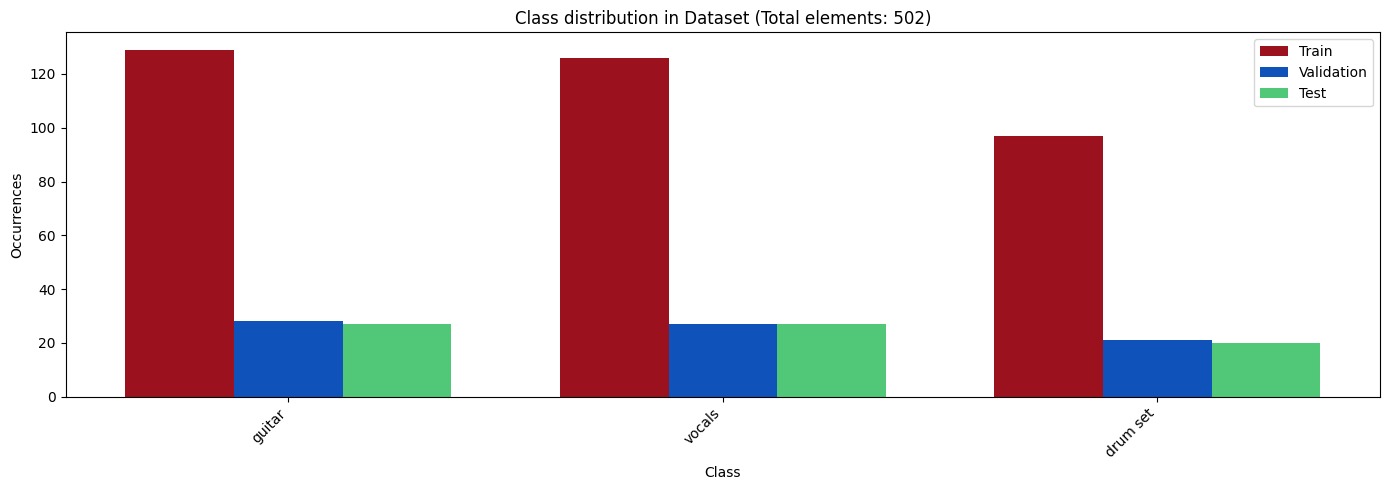

In [42]:
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_val, axis=0)
test_counts = np.sum(y_test, axis=0)

ruby = '#9B111E'
sapphire = '#0F52BA'
emerald = '#50C878'

labelsChart = mlb.classes_
x = np.arange(len(labelsChart))  # posizione per ogni classe
width = 0.25  # larghezza delle barre

plt.figure(figsize=(14, 5))

# Barre
plt.bar(x - width, train_counts, width, label='Train', color=ruby)
plt.bar(x, val_counts, width, label='Validation', color=sapphire)
plt.bar(x + width, test_counts, width, label='Test', color=emerald)

# Asse x e titoli
plt.xticks(x, labelsChart, rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Occurrences')
plt.title(f'Class distribution in Dataset (Total elements: {np.sum(labelsToLoad)})')
plt.legend()
plt.tight_layout()
plt.show()

In [122]:
import random
import scipy.ndimage

def padding(newSpec, originalShape):
    newShape = newSpec.shape
    out = np.zeros(originalShape, dtype=newSpec.dtype)
    h = min(originalShape[0], newShape[0])
    w = min(originalShape[1], newShape[1])
    out[:h, :w] = newSpec[:h, :w]
    return out

def augmenter(spegram):
    originalShape = spegram.shape
    modifications = []

    # Time stretch
    if random.random() < 0.75:
        rate = random.uniform(0.5, 1.5)
        stretched = scipy.ndimage.zoom(spegram, (1, rate), order=1)
        spegram = padding(stretched, originalShape)
        modifications.append(f"time_stretch({rate:.2f})")

    # Pitch shift
    if random.random() < 0.75:
        semitones = random.uniform(-12, 12)
        freqFactor = 2 ** (semitones / 12)
        shifted = scipy.ndimage.zoom(spegram, (freqFactor, 1), order=1)
        spegram = padding(shifted, originalShape)
        modifications.append(f"pitch_shift({semitones:.2f})")

    if not modifications:
        modifications.append("none")

    return spegram, modifications

['time_stretch(0.78)', 'pitch_shift(7.56)']


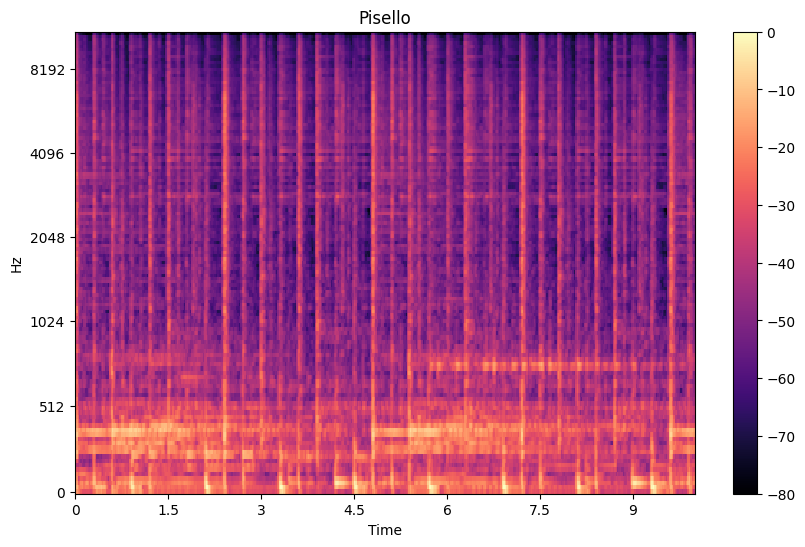

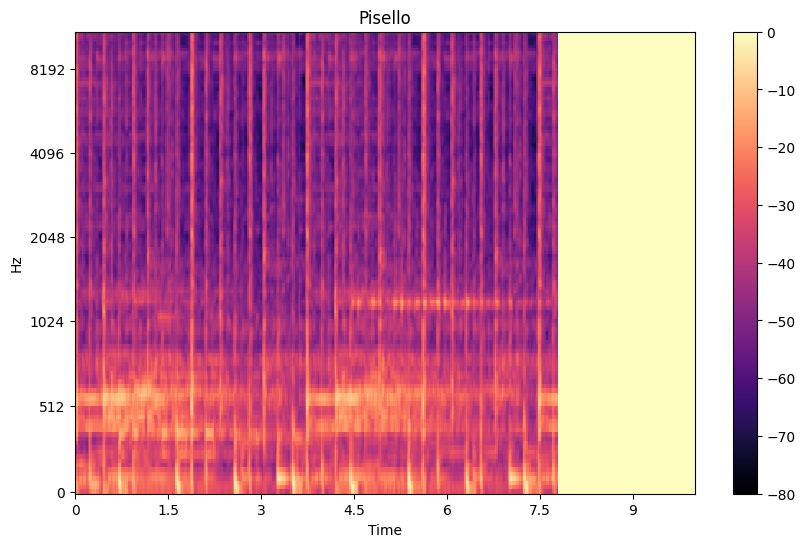

In [127]:
newSpec, mod = augmenter(melSpegrams[0])
print(mod)
plt.figure(figsize=(10,6))
librosa.display.specshow(melSpegrams[0], sr=22050, x_axis='time', y_axis='mel', fmax=22050/2)
plt.clim(-80,None)
plt.colorbar()
plt.title(f'Pisello')
plt.show()


plt.figure(figsize=(10,6))
librosa.display.specshow(newSpec, sr=22050, x_axis='time', y_axis='mel', fmax=22050/2)
plt.clim(-80,None)
plt.colorbar()
plt.title(f'Pisello')
plt.show()

In [43]:
# === Define input shape and number of output classes ===
inputShape = (128, melSpegrams[0].shape[1], 1)  # (n_mels, time_frames, channels)
numClasses = labelsToLoad.shape[1]              # number of multilabel classes

# === Build CNN model ===
modelCNN = models.Sequential([

    # Input
    layers.Input(shape=inputShape),

    # === Block 1 ===
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),

    # === Block 2 ===
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),

    # === Block 3 ===
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),

    # === Block 4 ===
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.25),

    # === Fully Connected ===
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),

    # === Output Layer (sigmoid for multilabel) ===
    layers.Dense(numClasses, activation='sigmoid')
])

# === Compile the model ===
from keras.metrics import BinaryAccuracy, AUC
modelCNN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='binary_accuracy'), AUC(multi_label=True, name='auc')]
)

# === Summary ===
modelCNN.summary()

# Optional: show classes
print(f"Number of classes: {numClasses}")
print(f"Class names: {mlb.classes_}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 431, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 431, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 43, 144, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 43, 144, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 43, 144, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 43, 144, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 16, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 16, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,437,923 (5.49 MB)

 Trainable params: 1,437,923 (5.49 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 3
Class names: ['guitar' 'vocals' 'drum set']


In [44]:
# Path to save logs and models
csvLogPath = 'training_log.csv'
checkpointPath = 'best_model.h5'

# CSVLogger: logs every epoch to CSV
csvLogger = CSVLogger(csvLogPath, append=True)

# EarlyStopping: stop if val_loss doesn't improve after 100 epochs
earlyStop = EarlyStopping(
    monitor='val_binary_accuracy',
    patience=100,
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint: save best model based on val_accuracy
checkpoint = ModelCheckpoint(
    filepath=checkpointPath,
    monitor='val_binary_accuracy',
    save_best_only=True,
    verbose=1
)

# Bundle them
callbacks = [csvLogger, earlyStop, checkpoint]

In [45]:
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
modelCNN.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='binary_accuracy'), AUC(multi_label=True, name='auc')]
)

batchSize=32
epochs=300

history = modelCNN.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batchSize, epochs=epochs, verbose=0, callbacks = callbacks)



Epoch 1: val_binary_accuracy improved from -inf to 0.58470, saving model to best_model.h5



Epoch 2: val_binary_accuracy did not improve from 0.58470

Epoch 3: val_binary_accuracy did not improve from 0.58470

Epoch 4: val_binary_accuracy did not improve from 0.58470

Epoch 5: val_binary_accuracy did not improve from 0.58470

Epoch 6: val_binary_accuracy did not improve from 0.58470

Epoch 7: val_binary_accuracy improved from 0.58470 to 0.65027, saving model to best_model.h5



Epoch 8: val_binary_accuracy did not improve from 0.65027

Epoch 9: val_binary_accuracy improved from 0.65027 to 0.73770, saving model to best_model.h5



Epoch 10: val_binary_accuracy did not improve from 0.73770

Epoch 11: val_binary_accuracy improved from 0.73770 to 0.75410, saving model to best_model.h5



Epoch 12: val_binary_accuracy improved from 0.75410 to 0.80328, saving model to best_model.h5



Epoch 13: val_binary_accuracy did not improve from 0.80328

Epoch 14: val_binary_accuracy did not improve from 0.80328

Epoch 15: val_binary_accuracy did not improve from 0.80328

Epoch 16: val_binary_accuracy did not improve from 0.80328

Epoch 17: val_binary_accuracy improved from 0.80328 to 0.84699, saving model to best_model.h5



Epoch 18: val_binary_accuracy did not improve from 0.84699

Epoch 19: val_binary_accuracy did not improve from 0.84699

Epoch 20: val_binary_accuracy did not improve from 0.84699

Epoch 21: val_binary_accuracy did not improve from 0.84699

Epoch 22: val_binary_accuracy did not improve from 0.84699

Epoch 23: val_binary_accuracy improved from 0.84699 to 0.85246, saving model to best_model.h5



Epoch 24: val_binary_accuracy did not improve from 0.85246

Epoch 25: val_binary_accuracy improved from 0.85246 to 0.86885, saving model to best_model.h5



Epoch 26: val_binary_accuracy did not improve from 0.86885

Epoch 27: val_binary_accuracy did not improve from 0.86885

Epoch 28: val_binary_accuracy did not improve from 0.86885

Epoch 29: val_binary_accuracy did not improve from 0.86885

Epoch 30: val_binary_accuracy did not improve from 0.86885

Epoch 31: val_binary_accuracy did not improve from 0.86885

Epoch 32: val_binary_accuracy did not improve from 0.86885

Epoch 33: val_binary_accuracy did not improve from 0.86885

Epoch 34: val_binary_accuracy did not improve from 0.86885

Epoch 35: val_binary_accuracy did not improve from 0.86885

Epoch 36: val_binary_accuracy improved from 0.86885 to 0.89617, saving model to best_model.h5



Epoch 37: val_binary_accuracy did not improve from 0.89617

Epoch 38: val_binary_accuracy did not improve from 0.89617

Epoch 39: val_binary_accuracy did not improve from 0.89617

Epoch 40: val_binary_accuracy did not improve from 0.89617

Epoch 41: val_binary_accuracy improved from 0.89617 to 0.90164, saving model to best_model.h5



Epoch 42: val_binary_accuracy did not improve from 0.90164

Epoch 43: val_binary_accuracy did not improve from 0.90164

Epoch 44: val_binary_accuracy did not improve from 0.90164

Epoch 45: val_binary_accuracy did not improve from 0.90164

Epoch 46: val_binary_accuracy did not improve from 0.90164

Epoch 47: val_binary_accuracy did not improve from 0.90164

Epoch 48: val_binary_accuracy did not improve from 0.90164

Epoch 49: val_binary_accuracy did not improve from 0.90164

Epoch 50: val_binary_accuracy did not improve from 0.90164

Epoch 51: val_binary_accuracy did not improve from 0.90164

Epoch 52: val_binary_accuracy did not improve from 0.90164

Epoch 53: val_binary_accuracy did not improve from 0.90164

Epoch 54: val_binary_accuracy did not improve from 0.90164

Epoch 55: val_binary_accuracy did not improve from 0.90164

Epoch 56: val_binary_accuracy did not improve from 0.90164

Epoch 57: val_binary_accuracy did not improve from 0.90164

Epoch 58: val_binary_accuracy did not i


Epoch 63: val_binary_accuracy did not improve from 0.90710

Epoch 64: val_binary_accuracy did not improve from 0.90710

Epoch 65: val_binary_accuracy did not improve from 0.90710

Epoch 66: val_binary_accuracy did not improve from 0.90710

Epoch 67: val_binary_accuracy did not improve from 0.90710

Epoch 68: val_binary_accuracy did not improve from 0.90710

Epoch 69: val_binary_accuracy did not improve from 0.90710

Epoch 70: val_binary_accuracy did not improve from 0.90710

Epoch 71: val_binary_accuracy did not improve from 0.90710

Epoch 72: val_binary_accuracy did not improve from 0.90710

Epoch 73: val_binary_accuracy did not improve from 0.90710

Epoch 74: val_binary_accuracy did not improve from 0.90710

Epoch 75: val_binary_accuracy did not improve from 0.90710

Epoch 76: val_binary_accuracy did not improve from 0.90710

Epoch 77: val_binary_accuracy did not improve from 0.90710

Epoch 78: val_binary_accuracy did not improve from 0.90710

Epoch 79: val_binary_accuracy did not i


Epoch 141: val_binary_accuracy did not improve from 0.91257

Epoch 142: val_binary_accuracy did not improve from 0.91257

Epoch 143: val_binary_accuracy did not improve from 0.91257

Epoch 144: val_binary_accuracy did not improve from 0.91257

Epoch 145: val_binary_accuracy did not improve from 0.91257

Epoch 146: val_binary_accuracy did not improve from 0.91257

Epoch 147: val_binary_accuracy did not improve from 0.91257

Epoch 148: val_binary_accuracy did not improve from 0.91257

Epoch 149: val_binary_accuracy did not improve from 0.91257

Epoch 150: val_binary_accuracy did not improve from 0.91257

Epoch 151: val_binary_accuracy did not improve from 0.91257

Epoch 152: val_binary_accuracy did not improve from 0.91257

Epoch 153: val_binary_accuracy did not improve from 0.91257

Epoch 154: val_binary_accuracy did not improve from 0.91257

Epoch 155: val_binary_accuracy did not improve from 0.91257

Epoch 156: val_binary_accuracy did not improve from 0.91257

Epoch 157: val_binary_a


Epoch 173: val_binary_accuracy did not improve from 0.91257

Epoch 174: val_binary_accuracy did not improve from 0.91257

Epoch 175: val_binary_accuracy did not improve from 0.91257

Epoch 176: val_binary_accuracy did not improve from 0.91257

Epoch 177: val_binary_accuracy did not improve from 0.91257

Epoch 178: val_binary_accuracy did not improve from 0.91257

Epoch 179: val_binary_accuracy did not improve from 0.91257

Epoch 180: val_binary_accuracy did not improve from 0.91257

Epoch 181: val_binary_accuracy did not improve from 0.91257

Epoch 182: val_binary_accuracy did not improve from 0.91257

Epoch 183: val_binary_accuracy did not improve from 0.91257

Epoch 184: val_binary_accuracy did not improve from 0.91257

Epoch 185: val_binary_accuracy did not improve from 0.91257

Epoch 186: val_binary_accuracy did not improve from 0.91257

Epoch 187: val_binary_accuracy did not improve from 0.91257

Epoch 188: val_binary_accuracy did not improve from 0.91257

Epoch 189: val_binary_a


Epoch 205: val_binary_accuracy did not improve from 0.91803

Epoch 206: val_binary_accuracy did not improve from 0.91803

Epoch 207: val_binary_accuracy did not improve from 0.91803

Epoch 208: val_binary_accuracy did not improve from 0.91803

Epoch 209: val_binary_accuracy did not improve from 0.91803

Epoch 210: val_binary_accuracy did not improve from 0.91803

Epoch 211: val_binary_accuracy did not improve from 0.91803

Epoch 212: val_binary_accuracy did not improve from 0.91803

Epoch 213: val_binary_accuracy did not improve from 0.91803

Epoch 214: val_binary_accuracy did not improve from 0.91803

Epoch 215: val_binary_accuracy did not improve from 0.91803

Epoch 216: val_binary_accuracy did not improve from 0.91803

Epoch 217: val_binary_accuracy did not improve from 0.91803

Epoch 218: val_binary_accuracy did not improve from 0.91803

Epoch 219: val_binary_accuracy did not improve from 0.91803

Epoch 220: val_binary_accuracy did not improve from 0.91803

Epoch 221: val_binary_a


Epoch 244: val_binary_accuracy did not improve from 0.92350

Epoch 245: val_binary_accuracy did not improve from 0.92350

Epoch 246: val_binary_accuracy did not improve from 0.92350

Epoch 247: val_binary_accuracy did not improve from 0.92350

Epoch 248: val_binary_accuracy did not improve from 0.92350

Epoch 249: val_binary_accuracy did not improve from 0.92350

Epoch 250: val_binary_accuracy did not improve from 0.92350

Epoch 251: val_binary_accuracy did not improve from 0.92350

Epoch 252: val_binary_accuracy did not improve from 0.92350

Epoch 253: val_binary_accuracy did not improve from 0.92350

Epoch 254: val_binary_accuracy did not improve from 0.92350

Epoch 255: val_binary_accuracy did not improve from 0.92350

Epoch 256: val_binary_accuracy did not improve from 0.92350

Epoch 257: val_binary_accuracy did not improve from 0.92350

Epoch 258: val_binary_accuracy did not improve from 0.92350

Epoch 259: val_binary_accuracy did not improve from 0.92350

Epoch 260: val_binary_a

KeyError: 'f1_score'

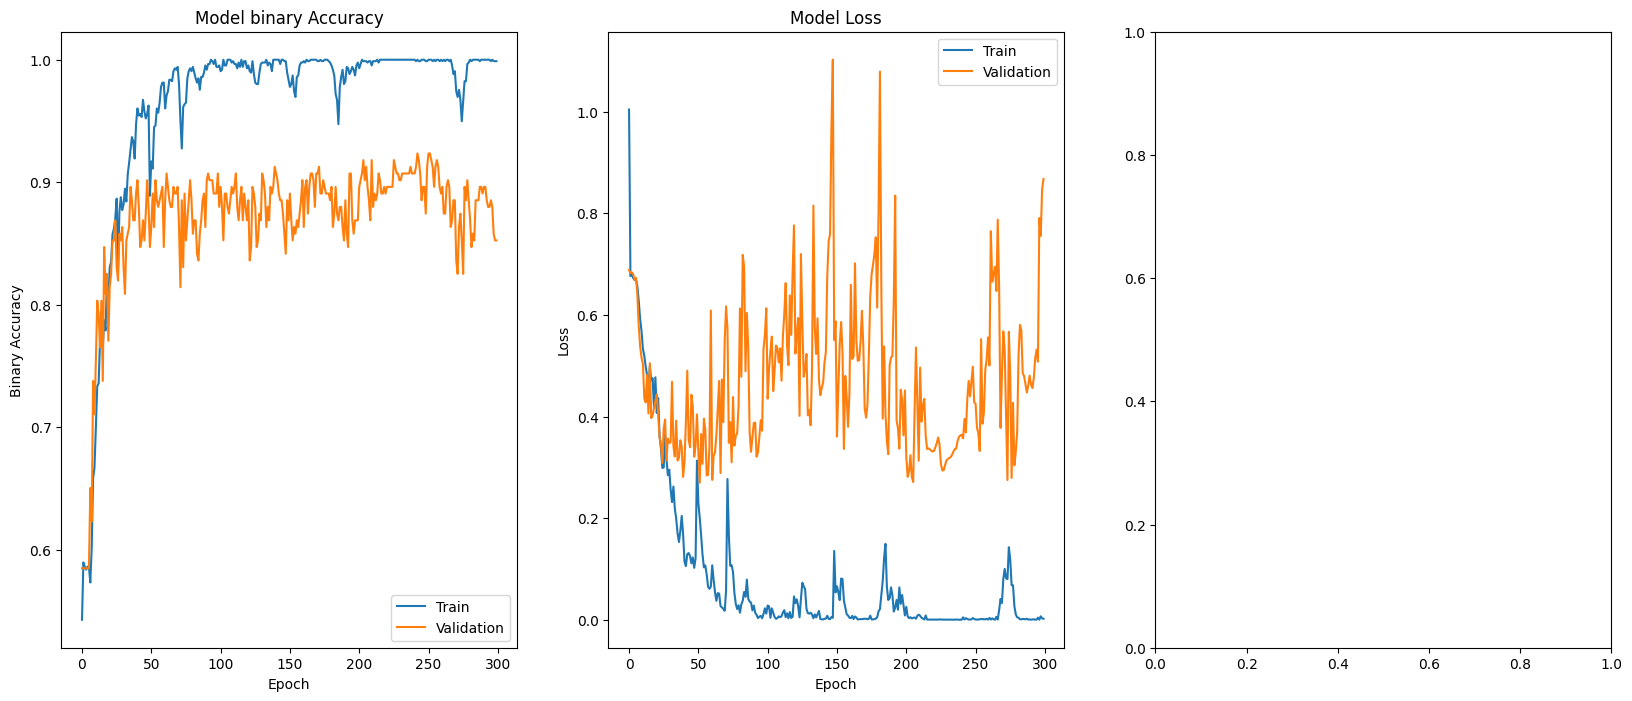

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(history.history['binary_accuracy']) 
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend(['Train', 'Validation'])
#plt.ylim(0, 3);

plt.subplot(1,2,2)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
#plt.ylim(0, 2);

#best validation accuracy
bestValAccuracy = np.max(history.history['val_binary_accuracy'])
print('Best validation accuracy: ', bestValAccuracy)

In [47]:
# Esegui evaluate e visualizza il risultato
results = modelCNN.evaluate(X_test, y_test, verbose=0)
print(results)  # Stampa i risultati per vedere quanti valori vengono restituiti

# Se sono più di 2 valori, puoi selezionare quello che ti interessa
testLoss = results[0]
testAccuracy = results[1]  # Oppure index corretti se ci sono più metriche

print(f"Test Loss: {testLoss:.4f}")
print(f"Test Accuracy: {testAccuracy:.4f}")

[0.6286171674728394, 0.9111111164093018, 0.9449646472930908]
Test Loss: 0.6286
Test Accuracy: 0.9111


In [48]:
modelCNN.load_weights('best_model.h5', by_name=False)

resultsTest = modelCNN.evaluate(X_test, y_test)
print('Test Loss: {} \nTest Accuracy: {}'.format(resultsTest[0], resultsTest[1]))

resultsVal = modelCNN.evaluate(X_val, y_val)
print('Val Loss: {} \nVal Accuracy: {}'.format(resultsVal[0], resultsVal[1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - auc: 0.9321 - binary_accuracy: 0.8956 - loss: 0.7793
Test Loss: 0.6286171674728394 
Test Accuracy: 0.9111111164093018
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - auc: 0.9584 - binary_accuracy: 0.9247 - loss: 0.3847
Val Loss: 0.39529287815093994 
Val Accuracy: 0.9234973192214966


In [49]:
# Predict the labels of the test set
threshold = 0.5
y_pred_probs = modelCNN.predict(X_test)                     # returns probabilities for each label (from sigmoid outputs)
y_pred_binary = (y_pred_probs > threshold).astype(int)      # if the probability of a class is higher then treshold then consider it active

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step


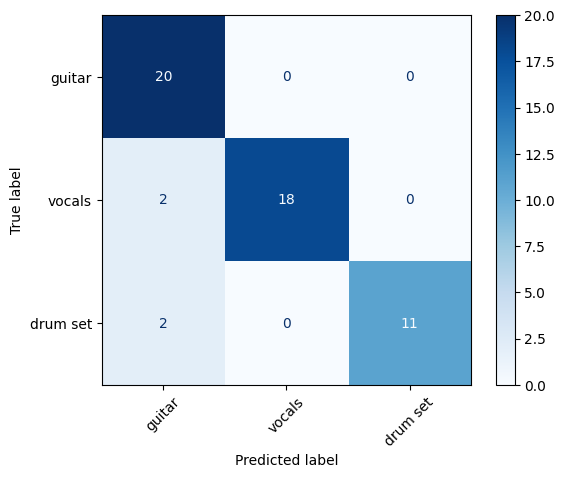

In [ ]:
# Confusion matrix considering the MIX as a separate lable:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert y_test back to normal label names or "MIX"
y_test_simplified = []
y_pred_simplified = []

i = 0

for row in y_test:
    active_indicesTest = np.where(row == 1)[0] # indices of the MLB lable in which the there is a 1 and not a 0
    active_indicesPred = np.where(y_pred_binary[i] == 1)[0]
    if len(active_indicesTest) == 1:
        y_test_simplified.append(mlb.classes_[active_indicesTest[0]])
        y_pred_simplified.append(mlb.classes_[active_indicesPred[0]])

    i += 1

# Print confusion matrix
allLabels = list(mlb.classes_)

cm = confusion_matrix(y_test_simplified, y_pred_simplified, labels=allLabels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=allLabels)
disp.plot(cmap="Blues", xticks_rotation=45)

In [112]:
def plot_mel(mel_spec, title=""):
    plt.figure(figsize=(6, 3))
    plt.imshow(mel_spec, origin='lower', aspect='auto', cmap='magma')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def inspect_mix_errors(y_test, y_pred_binary, mlb, X_data=None, max_samples=10, plot=True):
    mix_indices = [i for i, row in enumerate(y_test) if np.sum(row) > 1]
    print(f"Found {len(mix_indices)} MIX samples (multi-label). Showing up to {max_samples}:\n")

    for idx in mix_indices[:max_samples]:
        true_labels = set(mlb.inverse_transform(np.expand_dims(y_test[idx], axis=0))[0])
        pred_labels = set(mlb.inverse_transform(np.expand_dims(y_pred_binary[idx], axis=0))[0])

        missed = true_labels - pred_labels
        extra = pred_labels - true_labels
        correct = true_labels & pred_labels

        print(f"Sample #{idx}")
        print(f" -> Correct Prediction: {sorted(correct)}")
        print(f" -> False Negatives: {sorted(missed)}")
        print(f" -> False Positives: {sorted(extra)}")

        if plot and X_data is not None:
            plot_mel(X_data[idx], title=f"MIX Sample #{idx} | GT: {sorted(true_labels)}")


Found 7 MIX samples (multi-label). Showing up to 10:

Sample #0
 -> Correct Prediction: ['drum set', 'guitar']
 -> False Negatives: ['vocals']
 -> False Positives: []


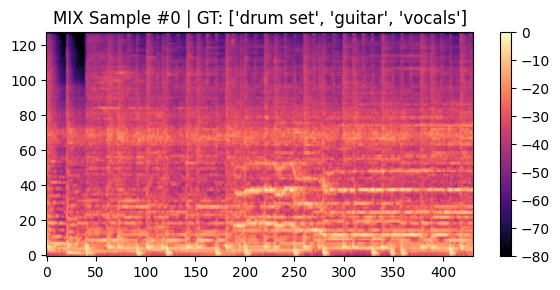

Sample #5
 -> Correct Prediction: ['guitar']
 -> False Negatives: ['drum set', 'vocals']
 -> False Positives: []


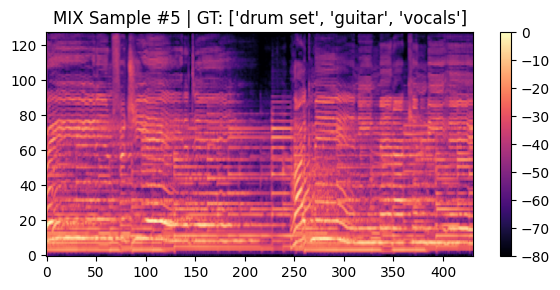

Sample #23
 -> Correct Prediction: ['drum set', 'guitar', 'vocals']
 -> False Negatives: []
 -> False Positives: []


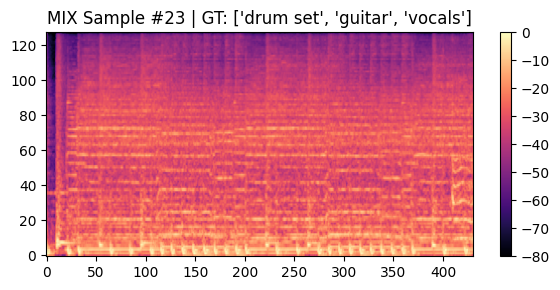

Sample #24
 -> Correct Prediction: []
 -> False Negatives: ['drum set', 'guitar', 'vocals']
 -> False Positives: []


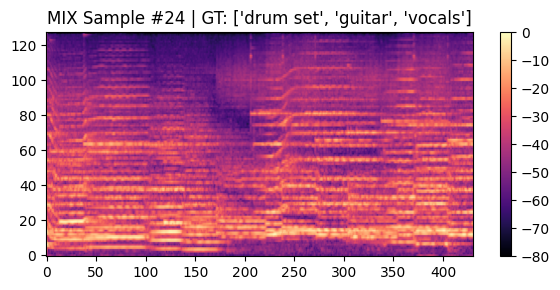

Sample #31
 -> Correct Prediction: ['guitar']
 -> False Negatives: ['drum set', 'vocals']
 -> False Positives: []


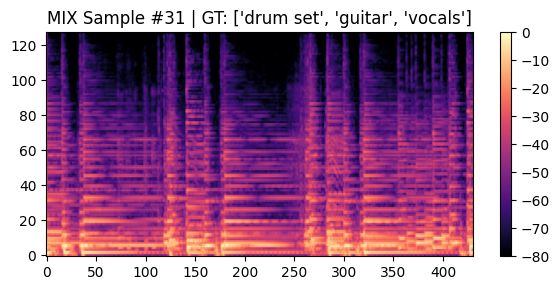

Sample #44
 -> Correct Prediction: ['drum set', 'guitar', 'vocals']
 -> False Negatives: []
 -> False Positives: []


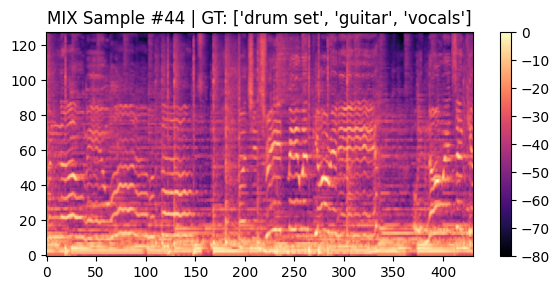

Sample #56
 -> Correct Prediction: ['vocals']
 -> False Negatives: ['drum set', 'guitar']
 -> False Positives: []


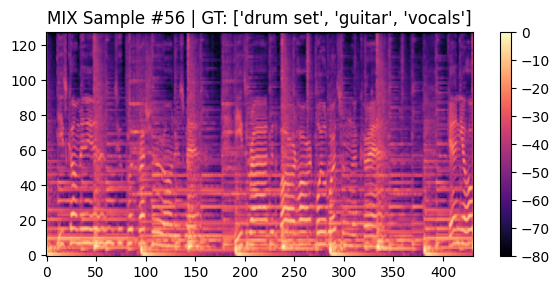

In [113]:
inspect_mix_errors(y_test, y_pred_binary, mlb, max_samples=10, X_data=X_test)

In [79]:
import pandas as pd
import numpy as np

def get_mix_matrix(y_true, y_pred, mlb, max_samples=10):
    rows = []

    # Trova MIX (campioni con più di una etichetta)
    mix_indices = [i for i, row in enumerate(y_true) if np.sum(row) > 1]

    for idx in mix_indices[:max_samples]:
        true_labels = set(mlb.inverse_transform([y_true[idx]])[0])
        pred_labels = set(mlb.inverse_transform([y_pred[idx]])[0])

        tp = sorted(true_labels & pred_labels)
        fn = sorted(true_labels - pred_labels)
        fp = sorted(pred_labels - true_labels)

        rows.append({
            'Sample': idx,
            'True Labels': sorted(true_labels),
            'Pred Labels': sorted(pred_labels),
            'TP': tp,
            'FN': fn,
            'FP': fp
        })

    df_mix = pd.DataFrame(rows)
    return df_mix


In [80]:
df_mix_analysis = get_mix_matrix(y_test, y_pred_binary, mlb, max_samples=15)
print(df_mix_analysis.to_string(index=False))


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# Classification report
from sklearn.metrics import classification_report

report = classification_report(
    y_test,
    y_pred_binary,
    target_names=mlb.classes_,
    zero_division=0  
)

print(report)